In [1]:
from os.path import join
import numpy as np
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pysal
plt.rcParams.update({'font.size': 22})
from scipy.stats import kurtosis, skew
from shapely.geometry import box, Polygon
from IPython.display import IFrame

# display map html when it's working again
#IFrame(src="../beira/idai_final.html", width = 800, height=500)

# Exploratory data analysis

The QGIS workflow used to generate *features.shp* generated a lot of duplicates, 1367738 extra rows in the GeoDataFrame. As a quick fix, dropping all geometry duplicates and keeping the first column, but later will need to return and fix the QGIS workflow. It might be better to do all of this in Python to keep things clean.

Old *featureset.shp* file had a lot of duplicates. I need to look at the QGIS workflow to figure out why. But for now, here is the code to read in the large *featureset.shp* file, drop duplicate geometries, keeping the first each time, and overwrite the *featureset.shp* file:
    
    import dask_geopandas
    d_gdf = dask_geopandas.read_file(join("..", "beira", "outdata", "featureset.shp"), npartitions=4)
    d_gdf = d_gdf.drop_duplicates(subset="geometry", keep="first").reset_index()
    d_gdf = d_gdf.compute()
    d_gdf.to_file(join("..", "beira", "outdata", "featureset.shp"))

In [5]:
d_gdf = gpd.read_file(join("..", "beira", "outdata", "featureset.shp"))

# check projection and re-project to ESPG:4326 (lon/lat)
d_gdf.crs  # EPSG:3857
print("features: " , *d_gdf.columns)
print("area of a grid square: ", d_gdf["geometry"].area.mean(), "m")

# re-project to EPSG:4326
d_gdf = d_gdf.to_crs("EPSG:4326")
print(d_gdf.columns)

features:  index id left top right bottom fabdem_avg slope_avg soilcb_avg pw_dist pw_angle floodfrac floodarea ndvi_mean evi_mean geometry
area of a grid square:  7.590731304533904e-05 m
Index(['index', 'id', 'left', 'top', 'right', 'bottom', 'fabdem_avg',
       'slope_avg', 'soilcb_avg', 'pw_dist', 'pw_angle', 'floodfrac',
       'floodarea', 'ndvi_mean', 'evi_mean', 'geometry'],
      dtype='object')


/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_13422/3324057954.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("area of a grid square: ", d_gdf["geometry"].area.mean(), "m")


    # check out the dask partitions -- for when you have a dask dataframe
    d_gdf.calculate_spatial_partitions() # convex hull
    fig, ax = plt.subplots(1,1, figsize=(12,6))
    d_gdf.spatial_partitions.plot(ax=ax, cmap="tab20", alpha=0.5)
    ax.set_axis_off()
    plt.show()

# Comparison to Muckley (2020) data

If I want to crop to the same area as Muckley (2020) uses in Mozambique, I need to convert the projections first. From [here](https://github.com/leomuckley/Multi-Input-ConvLSTM/tree/master/utils) I know the area of interest is:

    moz_aoi = ee.Geometry.Rectangle([ 33.69213642, -20.57556134,  35.30819006, -18.97632074])
    
These look like lon/lat projections so need to use `EPSG:4362`.
Then visualise both to check that they overlap okay and clip.

Muckley (2020) area: 34035296693.890228
My area: 1805999999.999980


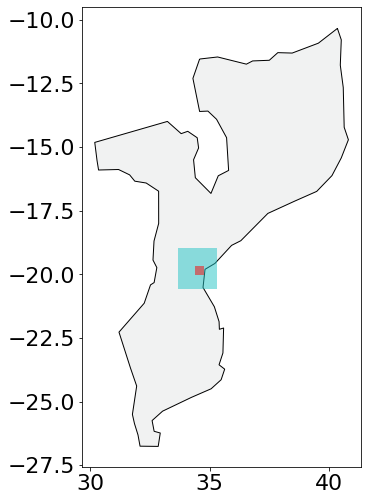

In [4]:
# boundary boxes for areas of interest
my_boundary = box(*d_gdf.total_bounds)
my_boundary = gpd.GeoSeries(my_boundary).set_crs("EPSG:4326")

muckley_boundary = box(33.69213642, -20.57556134,  35.30819006, -18.97632074)
muckley_boundary = gpd.GeoSeries(muckley_boundary).set_crs("EPSG:4326")

# visualise on a mamp of Mozambique
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mozambique = world.loc[world['name'] == 'Mozambique']['geometry']

fig, ax = plt.subplots(figsize=(5,10))
mozambique.plot(ax=ax, color='#f1f2f2', edgecolor='black')
muckley_boundary.plot(ax=ax, color='#21c4c5', alpha=0.5)
my_boundary.plot(ax=ax, color='red', alpha=0.5)

muckley_area = muckley_boundary.to_crs("EPSG:3857").area[0]
my_area = my_boundary.to_crs("EPSG:3857").area[0]
print("Muckley (2020) area:", '{:f}'.format(muckley_area))
print("My area:", '{:f}'.format(my_area))

So Muckley (2020) uses a much bigger spatial extent. Yet for Mozambique the paper states a count of 32200 or 32039 features are used (and I get 25920 when I run the code here) while I have 1369544 features. Muckley also uses 1sqkm squares with spatial grid staggering, so should have far more entries than me. It's a little odd that I have so many more inputs, let's compare the grids...

In [5]:
def make_grid(xmin, ymin, xmax, ymax):
    """ 
    Function for creating a grid using polygon objects. 
    
    Adapted from [1].
    Parameters
    ----------
    xmin : float, geo-coordinate
    ymin : float, geo-coordinate
    xmax : float, geo-coordinate
    ymax : float, geo-coordinate
    
    Returns
    -------
    grid : GeoDataFrame
    
    References:
    ..[1] Muckley (2020)
    """
    length = 0.01
    wide = 0.01
    

    cols = list(np.arange(xmin, xmax, wide))
    rows = list(np.arange(ymin, ymax, length))
    rows = rows[::-1]
    
    polygons = []
    for x in cols:
        for y in rows:
            polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )
    
    grid = gpd.GeoDataFrame({'geometry':polygons}).set_crs("EPSG:4326")
    return grid 

In [6]:
# load in ESPG:4326
muckley_grid = make_grid(33.69213642, -20.57556134,  35.30819006, -18.97632074)
my_grid = d_gdf.boundary

# switch to Pseudo-Mercator projection (this is in meters)
muckley_grid_pm = muckley_grid.to_crs("EPSG:3857")
my_grid_pm = my_grid.to_crs("EPSG:3857")

# let's have a look at the polygon dimensions in meters...
print("Metres:\n--------")
# get areas
print("Muckley (2020) grid area: ",
      muckley_grid_pm.iloc[0, :]["geometry"].area,
      "\nMuckley (2020) side length: ",
      muckley_grid_pm.iloc[0, :]["geometry"].length / 4)
      
# get side lengths
print("\nMy grid area: ",
      Polygon(my_grid_pm[0]).area,
      "\nMy grid side length: ",
      Polygon(my_grid_pm[0]).length / 4)


# ...and in degrees
print("\nDegrees:\n--------")

# get areas
print("Muckley (2020) grid area: ",
      np.round(muckley_grid.iloc[0, :]["geometry"].area, 4),
      "\nMuckley (2020) side length: ",
      np.round(muckley_grid.iloc[0, :]["geometry"].length / 4, 4))


# get side lengths
print("\nMy grid area: ",
      '{:f}'.format(np.round(Polygon(my_grid[0]).area, 6)),
      "\nMy grid side length: ",
      np.round(Polygon(my_grid[0]).length / 4, 4))

Metres:
--------
Muckley (2020) grid area:  1310532.3009028677 
Muckley (2020) side length:  1145.2330520830583

My grid area:  1000000.0 
My grid side length:  1000.0

Degrees:
--------
Muckley (2020) grid area:  0.0001 
Muckley (2020) side length:  0.01

My grid area:  0.000076 
My grid side length:  0.0087


This cell takes quite a while to run so here is the code and its output.

    # let's look at grids in Pseudo-Mercator and EPSG:4326
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    muckley_grid.plot(ax=ax[0], color="white", edgecolor="black")
    my_grid.plot(ax=ax[0], color="red")
    ax[0].set_title("EPSG:4326")

    muckley_grid_pm.plot(ax=ax[1], color="white", edgecolor="black")
    my_grid_pm.plot(ax=ax[1], color="red")
    ax[1].set_title("Pseudo-Mercator")

    # save it as a pdf so you can zoom it etc.
    fig.savefig("../beira/grid_compare.pdf")

<img src="../beira/grid_compare.png"> 

Seems like the differences are simply down to differences when using degree approximations versus meters to define the grid. Hopefully it won't affect things too much.

In [7]:
floodfrac = d_gdf.floodfrac
print("Summary statistics:\n-------------------")
print("count flood fraction:", len(floodfrac))
print("mean flood fraction:", np.round(np.mean(floodfrac), 4))
print("median flood fraction:", np.round(np.median(floodfrac), 4))

vals, counts = np.unique(floodfrac, return_counts=True)
index = np.argmax(counts)
print("mode flood fraction:", np.round(vals[index], 4))
print("std flood fraction:", np.round(np.std(floodfrac), 4))
print("kurtosis flood fraction:", np.round(kurtosis(floodfrac), 4))
print("skew flood fraction:", np.round(skew(floodfrac), 4))

Summary statistics:
-------------------
count flood fraction: 1806
mean flood fraction: 0.3376
median flood fraction: 0.2312
mode flood fraction: 0.0
std flood fraction: 0.347
kurtosis flood fraction: -1.2463
skew flood fraction: 0.526


Negative kurtosis means that the data seems to have fewer extreme values than a normal distribution would, these distributions often appear flat-toppped. The skew is low, and as is shown below, the flooding distribution appears almost uniform when you ignore the mode value 0, which aligns with the negative kurtosis value.

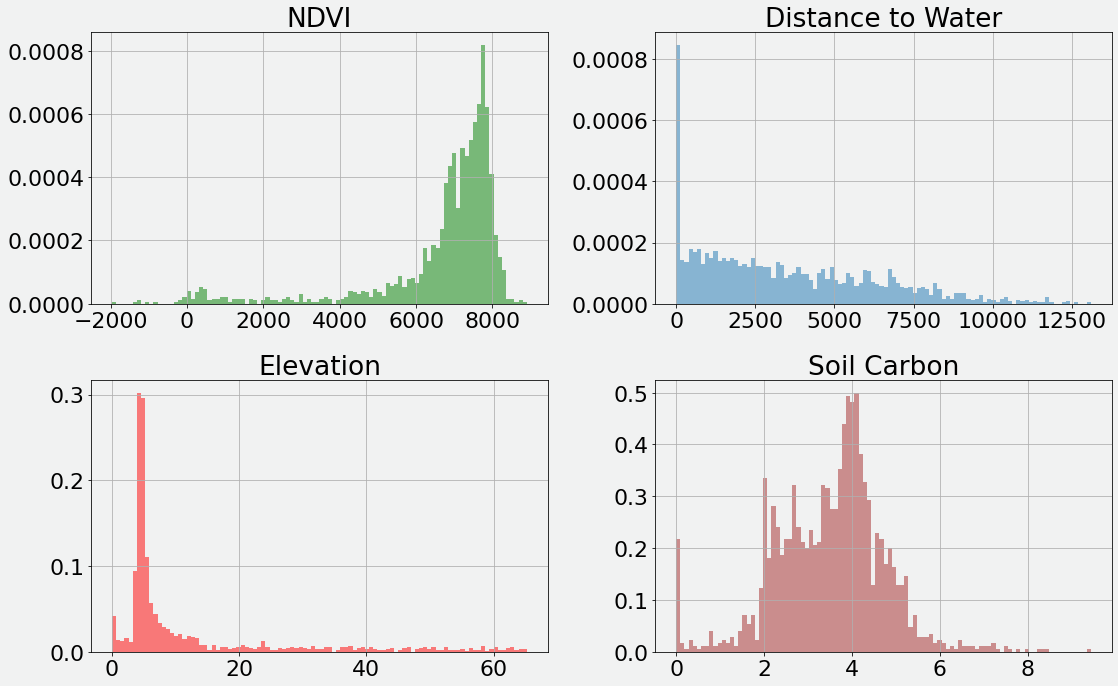

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), facecolor='#f1f2f2', tight_layout=True)

for i in range(2):
    for j in range(2):
        axs[i, j].set_facecolor("#f1f2f2")
        axs[i, j].grid()

axs[0, 0].hist(d_gdf.ndvi_mean, bins=100, alpha=0.5, density=True, color="green");
axs[0, 1].hist(d_gdf.pw_dist, bins=100, alpha=0.5, density=True);
axs[1, 0].hist(d_gdf.fabdem_avg, bins=100, alpha=0.5, density=True, color="red");
axs[1, 1].hist(d_gdf.soilcb_avg, bins=100, alpha=0.5, density=True, color="brown");

axs[0, 0].set_title("NDVI")
axs[0, 1].set_title("Distance to Water")
axs[1, 0].set_title("Elevation")
axs[1, 1].set_title("Soil Carbon");

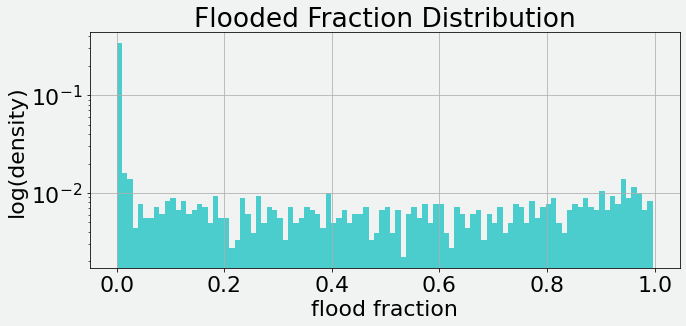

In [9]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='#f1f2f2', tight_layout=True)
ax.grid(zorder=1)

floodfrac = [*d_gdf.floodfrac]
weights = np.ones_like(floodfrac)/float(len(floodfrac))
ax.hist(floodfrac, bins=100, weights=weights, alpha=0.8, density=False, log=True, color="#21c4c5");
ax.set_ylabel("log(density)");
ax.set_xlabel("flood fraction");
ax.set_title("Flooded Fraction Distribution");
ax.set_facecolor("#f1f2f2")

The data is not that highly-skewed (skewness=0.4591 and kurtosis=-1.3076).

## Spatial autocorrelation
Maybe start with [this](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html) blog post about global spatial autocorrelation.

In [10]:
from pysal.lib import weights
from pysal.explore import esda

/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [11]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(d_gdf, k=8)
# Row-standardization
w.transform = 'R'

Moran's I-value for flood fraction: 0.84
p-value: 0.001


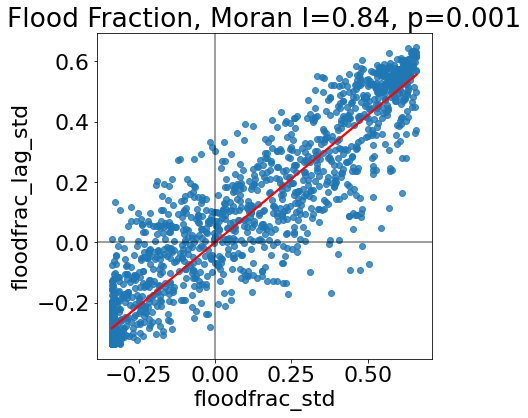

In [35]:
moran = esda.moran.Moran(d_gdf['floodfrac'], w)
moranI = np.round(moran.I, 2)
print(f"Moran's I-value for flood fraction: {moranI}")
print(f"p-value: {moran.p_sim}")

# now to create a Moran plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x='floodfrac_std',
    y='floodfrac_lag_std', 
    ci=None,
    data=d_gdf,
    line_kws={'color':'r'},
    
)
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title(f'Flood Fraction, Moran I={moranI}, p={moran.p_sim}')
plt.show()

There is a similar level of spatial autocorrelation to what Muckley (2020) found. This justifies our use of a convlutional layer.

In [36]:
d_gdf.columns

Index(['index', 'id', 'left', 'top', 'right', 'bottom', 'fabdem_avg',
       'slope_avg', 'soilcb_avg', 'pw_dist', 'pw_angle', 'floodfrac',
       'floodarea', 'ndvi_mean', 'evi_mean', 'geometry', 'floodfrac_lag',
       'floodfrac_std', 'floodfrac_lag_std'],
      dtype='object')

Moran's I-value for flood fraction: 0.57
p-value: 0.001


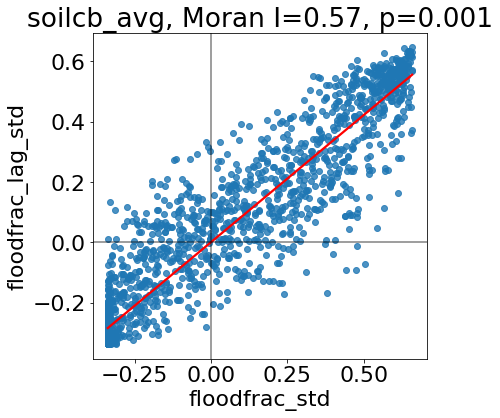

In [39]:
# cell to explore other input variable spatial relationships
feature = "soilcb_avg"

moran = esda.moran.Moran(d_gdf[feature], w)
moranI = np.round(moran.I, 2)
print(f"Moran's I-value for flood fraction: {moranI}")
print(f"p-value: {moran.p_sim}")

# now to create a Moran plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x='floodfrac_std',
    y='floodfrac_lag_std', 
    ci=None,
    data=d_gdf,
    line_kws={'color':'r'},
    
)
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title(f'{feature}, Moran I={moranI}, p={moran.p_sim}')
plt.show()